# Settings

In [1]:
!git clone https://github.com/QuocThinh73/HCMAI2025.git

Cloning into 'HCMAI2025'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 21 (delta 6), reused 17 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 13.89 KiB | 13.89 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
%cd HCMAI2025

/content/HCMAI2025


In [3]:
!mkdir -p data/keyframes faiss_index

Sau khi chạy các bước trên hãy thêm file zip vào thư mục data

In [4]:
import zipfile
import os

zip_path = "data/L08_V016.zip" # Đổi tên lại cho đúng
extract_dir = "data/keyframes/L08_V016" # Đổi tên lại cho đúng

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Build FAISS

In [6]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 71.5 MB/s eta 0:00:00


In [7]:
import glob

from data_preparation import build_faiss_index
from vlm import CLIPModel

In [10]:
image_paths = sorted(glob.glob("data/keyframes/L08_V016/*.jpg", recursive=True))

In [9]:
image_paths

['data/keyframes/L08_V016/L08_V016_Begin_1.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_10.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_100.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_101.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_102.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_103.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_104.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_105.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_106.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_107.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_108.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_109.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_11.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_110.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_111.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_112.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_113.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_114.jpg',
 'data/keyframes/L08_V016/L08_V016_Begin_115.jpg',
 'data/keyframes/L08_V016/L08_V016_

Thêm Hugging Face token vào notebook (nhìn thanh bên trái có hình chìa khóa). Đặt tên là HF_TOKEN và nhớ bật nút Notebook access

In [11]:
model = CLIPModel()

In [12]:
index, id2path = build_faiss_index(
        image_paths=image_paths,
        model=model,
        output_dir="faiss_index",
        batch_size=32,
        verbose=True
    )

Computing embeddings for 1083 images...


100%|██████████| 34/34 [00:28<00:00,  1.19it/s]

Building FAISS index with dimension 512...
FAISS index saved to faiss_index/faiss_index.bin
ID to path mapping saved to faiss_index/id2path.pkl


# Test

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

def display_results(paths, scores=None, max_images=5):
    """Display image results in Colab."""
    n = min(len(paths), max_images)
    fig, axes = plt.subplots(1, n, figsize=(15, 3))

    if n == 1:
        axes = [axes]

    for i in range(n):
        try:
            img = Image.open(paths[i])
            axes[i].imshow(img)
            if scores is not None:
                axes[i].set_title(f"Score: {scores[i]:.4f}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error displaying image {paths[i]}: {e}")

    plt.tight_layout()
    plt.show()

In [15]:
from translation import Translation
from faiss_index import FaissIndex

In [32]:
# Load FAISS index
index_path = "faiss_index/faiss_index.bin"
id2path_path = "faiss_index/id2path.pkl"

translator = Translation(backend="huggingface")

my_faiss = FaissIndex(
        index_path=index_path,
        id2path_path=id2path_path,
        model=model,
        translator=translator,
        top_k=5
    )

English: en The woman is being interviewed the woman is being interviewed the woman is being interviewed the woman is being
1. Score: 0.2716, Index: 521, Path: data/keyframes/L08_V016/L08_V016_End_243.jpg
2. Score: 0.2682, Index: 721, Path: data/keyframes/L08_V016/L08_V016_End_99.jpg
3. Score: 0.2676, Index: 495, Path: data/keyframes/L08_V016/L08_V016_End_22.jpg
4. Score: 0.2674, Index: 520, Path: data/keyframes/L08_V016/L08_V016_End_242.jpg
5. Score: 0.2674, Index: 312, Path: data/keyframes/L08_V016/L08_V016_Begin_55.jpg


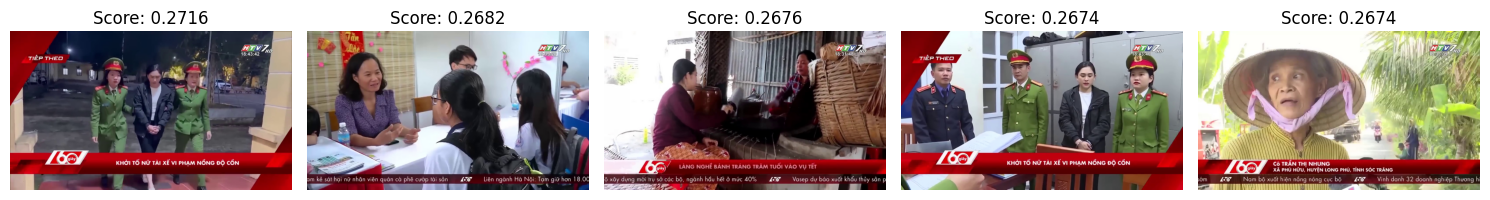

In [34]:
query = "Người phụ nữ đang được phỏng vấn"
print("English:", translator.__call__(query))
scores, indices, paths = my_faiss.text_search(query, top_k=5)

for i, (score, idx, path) in enumerate(zip(scores, indices, paths)):
           print(f"{i+1}. Score: {score:.4f}, Index: {idx}, Path: {path}")

display_results(paths, scores, 5)